<a href="https://colab.research.google.com/github/Sasuga-Ito/simulation_with_python/blob/main/1D_burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Δx: 1.0 Δt: 0.2 CFL: 0.2 ν: 0.5 d: 0.1


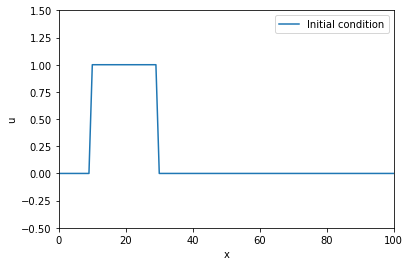

In [47]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg as spla
from scipy.sparse import csr_matrix
from matplotlib.animation import ArtistAnimation
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D


# Make stencils
# Creat square wave
Num_stencil_x = 101
x_array = np.arange(Num_stencil_x)
u_array = np.where(((x_array >= 30) |(x_array < 10)), 0.0, 1.0)
u_lower_boundary = 0.0
u_upper_boundary = 0.0
Time_step = 300
Delta_x = max(x_array) / (Num_stencil_x-1)
C = 1
Nu = 0.5
Delta_t = 0.2
CFL = C * Delta_t / Delta_x
diffusion_number = Nu * Delta_t / Delta_x**2
total_movement = C * Delta_t * (Time_step+1)
exact_u_array = np.where(((x_array >= 30 + total_movement) |(x_array < 10 + total_movement)), 0.0, 1.0)
plt.plot(x_array, u_array, label="Initial condition")
plt.legend(loc="upper right")
plt.xlabel("x")
plt.ylabel("u")
plt.xlim(0, max(x_array))
plt.ylim(-0.5,1.5)
print("Δx:", Delta_x, "Δt:", Delta_t, "CFL:", CFL, "ν:", Nu, "d:", diffusion_number)

In [48]:
def solve_advection_cip(u_cip, partial_u_cip, lower_boundary, dt=Delta_t, velocity=C):
    """
    CIP法によって移流方程式を解く
    """
    u_old = u_cip.copy()
    partial_u_old = partial_u_cip.copy()
    u_cip[0] = lower_boundary
    partial_u_cip[0] = (u_cip[0] - lower_boundary) / Delta_x
    a = (partial_u_old[1:] + partial_u_old[:-1]) / Delta_x**2 - 2.0 * np.diff(u_old, n=1) / Delta_x**3
    b = 3 * (u_old[:-1] - u_cip[1:]) / Delta_x**2 + (2.0*partial_u_old[1:] + partial_u_old[:-1]) / Delta_x
    c = partial_u_old[1:]
    d = u_old[1:]
    xi = - velocity * dt  # C > 0
    u_cip[1:] = a * xi**3 + b * xi**2 + c * xi + d
    partial_u_cip[1:] = 3 * a * xi**2 + 2 * b * xi + c
    return u_cip, partial_u_cip

def solve_diffusion(u_array, lower_boundary, upper_boundary, diffusion_number, 
                    update_partial=False, u_array_integral=None, prop_lambda=1/2):
    """
    拡散方程式を解く。

    Parameters
    ----------
    u_array : array-like
        nのベクトル
    upper_boundary : numpy.float64
        u_array[n]の隣
    lower_boundary : numpy.float64
        u_array[0]の隣
    diffusion_number : numpy.float64
        拡散数。正の数。
    update_partial : Bool, default False
        微分式の更新の時Trueにする。
    u_array_integral : array-like, default None
        微分式の更新の時に使用。[lower_boundary, u_array, upper_boudary]の形のn+2のベクトル。
    prop_lambda : numpy.float64, default 1/2
        0: Explicit method. Centered sapce difference.
        1/2: 半陰解法。Crank-Nicolson scheme
        1: Fully implicit method. 時間後退差分。

    Returns
    -------
    u_array : array-like
        n行の行列
    """
    a_matrix = np.identity(len(u_array)) * (1/diffusion_number+2 * prop_lambda) \
                - prop_lambda * np.eye(len(u_array), k=1) \
                - prop_lambda * np.eye(len(u_array), k=-1)
    temp_u_array = np.append(np.append(
                             lower_boundary, 
                             u_array), upper_boundary)
    b_array = (1/diffusion_number - 2 * (1-prop_lambda)) * u_array + (1-prop_lambda)*temp_u_array[2:] + (1-prop_lambda)*temp_u_array[:-2]
    b_array[0] += prop_lambda * lower_boundary
    b_array[-1] += prop_lambda * upper_boundary
    if update_partial:
        # 微分式の更新の時にこれを実行
        b_array -= ((u_array_integral[2:] - u_array_integral[:-2]) / 2 / Delta_x)**2
    a_csr = scipy.sparse.csr_matrix(a_matrix)
    u_array = spla.isolve.bicgstab(a_csr, b_array)[0]
    return u_array

fig = plt.figure(1)
images = []
u_cip= u_array.copy()
partial_u_cip = ((np.append(u_cip[1:], u_upper_boundary) + u_cip)/2 
                 - (np.append(u_lower_boundary, u_cip[:-1]) + u_cip)/2)/ Delta_x
# 安定条件の設定
cfl_condition = 1
diffusion_number_restriction = 1/2
# 時間発展させる
for n in range(Time_step):
    delta_t = Delta_t
    cfl_max = np.max(np.abs(u_cip)) * delta_t / Delta_x
    diffusion_max = Nu * delta_t / Delta_x**2
    if cfl_max > cfl_condition:
        # CFL条件の判定
        # cfl_conditionより大きかったら、時間刻み幅dtを小さくしてCFL条件を満たすようにする
        delta_t = cfl_condition * Delta_x / np.max(np.abs(u_cip))
    if diffusion_number > diffusion_number_restriction:
        # 拡散数の判定
        # diffusion_number_restrictionより大きかったら、時間刻み幅dtを小さくして拡散数の条件を満たすようにする
        delta_t = diffusion_max * Delta_x ** 2 / Nu
    # 移流方程式を解く
    u_cip_star, partial_u_cip_star = solve_advection_cip(u_cip, partial_u_cip, u_lower_boundary, delta_t, u_cip[1:])
    # 拡散方程式を解く
    u_cip = solve_diffusion(u_cip_star, u_lower_boundary, u_upper_boundary, diffusion_number)
    u_cip_with_boundary = np.append(np.append(
                                     u_lower_boundary, 
                                     u_cip_star), 
                                     u_upper_boundary)
    partial_u_cip = solve_diffusion(partial_u_cip_star, 0, 0, diffusion_number, 
                                    update_partial=True, 
                                    u_array_integral=u_cip_with_boundary)  # 境界値を0とした
    if n % 10 == 0:
        line, = plt.plot(x_array, u_cip, "r")
        images.append([line])
# plt.plot(x_array, u_array, label="Initial condition")
# plt.plot(x_array, u_cip, label="Burgers")
animatoin_gif = ArtistAnimation(fig, images)
# animatoin_gif.save('burgers.gif', writer="pillow")

rc('animation', html='jshtml')
plt.close()
animatoin_gif